# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from datetime import datetime
from functools import reduce

from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, min, max, split, udf
from pyspark.sql.types import IntegerType

from pyspark.mllib.evaluation import BinaryClassificationMetrics

from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import Normalizer, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, CrossValidatorModel

import re

In [2]:
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify Churn Analysis") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# load dataset
sparkify_event_data = 'medium-sparkify-event-data.json'
df = spark.read.json(sparkify_event_data)
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [4]:
df.head()

Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293')

In [5]:
df.describe().show()

+-------+-----------------+----------+---------+------+------------------+--------+------------------+------+----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+------------------+
|summary|           artist|      auth|firstName|gender|     itemInSession|lastName|            length| level|        location|method|   page|        registration|         sessionId|                song|            status|                  ts|           userAgent|            userId|
+-------+-----------------+----------+---------+------+------------------+--------+------------------+------+----------------+------+-------+--------------------+------------------+--------------------+------------------+--------------------+--------------------+------------------+
|  count|           432877|    543705|   528005|528005|            543705|  528005|            432877|543705|          528005|543705| 543705|          

#### Clean dataset

In [6]:
print((df.count(), len(df.columns)))

(543705, 18)


In [7]:
df.toPandas().isnull().sum()

artist           110828
auth                  0
firstName         15700
gender            15700
itemInSession         0
lastName          15700
length           110828
level                 0
location          15700
method                0
page                  0
registration      15700
sessionId             0
song             110828
status                0
ts                    0
userAgent         15700
userId                0
dtype: int64

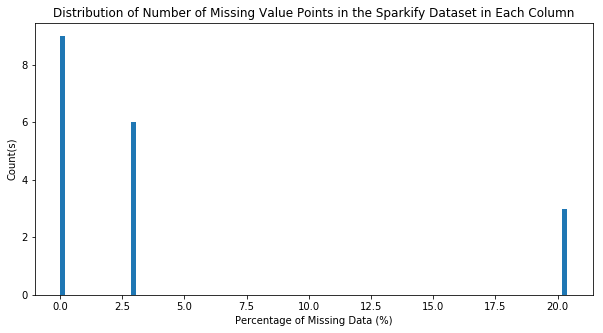

In [8]:
null_number = df.toPandas().isnull().sum()

plt.figure(figsize=(10, 5))
plt.title('Distribution of Number of Missing Value Points in the Sparkify Dataset in Each Column')
plt.hist(null_number / df.count() * 100, bins=100)
plt.xlabel('Percentage of Missing Data (%)')
plt.ylabel('Count(s)')
plt.show()

In [9]:
# Investigate patterns in the amount of missing data in each column
data_under_2 = (null_number / df.count() * 100) <= 2
data_over_2 = (null_number / df.count() * 100) > 2
attri_over_2 = null_number.loc[(null_number / df.count() * 100) > 2]
print("Attributes with equal to or under 2% of missing data: {}".format(data_under_2.sum()))
print("Attributes with over 2% of missing data: {}".format(data_over_2.sum()))
print("Attributes with missing data that exceeds 2%: \n{}".format(attri_over_2 / df.count() * 100))

Attributes with equal to or under 2% of missing data: 9
Attributes with over 2% of missing data: 9
Attributes with missing data that exceeds 2%: 
artist          20.383848
firstName        2.887595
gender           2.887595
lastName         2.887595
length          20.383848
location         2.887595
registration     2.887595
song            20.383848
userAgent        2.887595
dtype: float64


In [10]:
# Remove the outlier columns from the dataset
df = df.drop(*['artist', 'firstname', 'gender', 'lastname', 'length', 'location', 'registration', 'song', 'userAgent'])
df.show()

+----------+-------------+-----+------+---------------+---------+------+-------------+------+
|      auth|itemInSession|level|method|           page|sessionId|status|           ts|userId|
+----------+-------------+-----+------+---------------+---------+------+-------------+------+
| Logged In|           20| free|   PUT|       NextSong|      292|   200|1538352011000|   293|
| Logged In|           74| free|   PUT|       NextSong|       97|   200|1538352025000|    98|
| Logged In|          184| paid|   PUT|       NextSong|      178|   200|1538352118000|   179|
| Logged In|          185| paid|   PUT|         Logout|      178|   307|1538352119000|   179|
| Logged In|           22| paid|   PUT|       NextSong|      245|   200|1538352124000|   246|
| Logged In|          266| paid|   PUT|       NextSong|      162|   200|1538352125000|   163|
|Logged Out|          186| paid|   GET|           Home|      178|   200|1538352148000|      |
|Logged Out|          187| paid|   GET|           Home|     

In [11]:
df.toPandas().isnull().sum()

auth             0
itemInSession    0
level            0
method           0
page             0
sessionId        0
status           0
ts               0
userId           0
dtype: int64

In [12]:
# filter out empty user ID from earlier dataset exploration
df = df.filter(df.userId != "")
df.count()

528005

In [13]:
# look at all the possible 'auth', 'level', and 'page' attributes 
df.select(["auth", "level", "page"]).dropDuplicates().sort("auth").show()

+---------+-----+--------------------+
|     auth|level|                page|
+---------+-----+--------------------+
|Cancelled| free|Cancellation Conf...|
|Cancelled| paid|Cancellation Conf...|
|Logged In| free|            Settings|
|Logged In| free|              Logout|
|Logged In| free|                Help|
|Logged In| paid|       Save Settings|
|Logged In| paid|               About|
|Logged In| free|         Thumbs Down|
|Logged In| paid|              Logout|
|Logged In| free|         Roll Advert|
|Logged In| free|           Thumbs Up|
|Logged In| paid|         Thumbs Down|
|Logged In| paid|                Home|
|Logged In| paid|           Thumbs Up|
|Logged In| paid|          Add Friend|
|Logged In| paid|    Submit Downgrade|
|Logged In| free|            NextSong|
|Logged In| paid|              Cancel|
|Logged In| free|               About|
|Logged In| free|      Submit Upgrade|
+---------+-----+--------------------+
only showing top 20 rows



In [14]:
# look at all the possible 'auth', 'gender', and 'ts' attributes
df.select(["auth", "page", "ts"]).dropDuplicates().sort("auth").show()

+---------+--------------------+-------------+
|     auth|                page|           ts|
+---------+--------------------+-------------+
|Cancelled|Cancellation Conf...|1542404708000|
|Cancelled|Cancellation Conf...|1542206187000|
|Cancelled|Cancellation Conf...|1542032682000|
|Cancelled|Cancellation Conf...|1541087401000|
|Cancelled|Cancellation Conf...|1541507600000|
|Cancelled|Cancellation Conf...|1541302069000|
|Cancelled|Cancellation Conf...|1539254318000|
|Cancelled|Cancellation Conf...|1542159866000|
|Cancelled|Cancellation Conf...|1543091855000|
|Cancelled|Cancellation Conf...|1538507591000|
|Cancelled|Cancellation Conf...|1543522398000|
|Cancelled|Cancellation Conf...|1538987586000|
|Cancelled|Cancellation Conf...|1539831896000|
|Cancelled|Cancellation Conf...|1542360575000|
|Cancelled|Cancellation Conf...|1541958736000|
|Cancelled|Cancellation Conf...|1538647095000|
|Cancelled|Cancellation Conf...|1542828929000|
|Cancelled|Cancellation Conf...|1542147643000|
|Cancelled|Ca

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

#### Defining churn as people who cancelled Sparkify (users who have "Cancelled Confirmation" page events)

In [15]:
df.select(["page"]).dropDuplicates().sort("page").collect()

[Row(page='About'),
 Row(page='Add Friend'),
 Row(page='Add to Playlist'),
 Row(page='Cancel'),
 Row(page='Cancellation Confirmation'),
 Row(page='Downgrade'),
 Row(page='Error'),
 Row(page='Help'),
 Row(page='Home'),
 Row(page='Logout'),
 Row(page='NextSong'),
 Row(page='Roll Advert'),
 Row(page='Save Settings'),
 Row(page='Settings'),
 Row(page='Submit Downgrade'),
 Row(page='Submit Upgrade'),
 Row(page='Thumbs Down'),
 Row(page='Thumbs Up'),
 Row(page='Upgrade')]

#### Cells below are for exploring the data

In [16]:
# function for converting Row object to string
convert_row_to_string = lambda x, y: x.asDict()[y]

# function for plotting distribution
def plot(dfList, attr: str):
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    for i, (df, auth) in enumerate(zip(dfList, ['Churned Users', 'Stayed Users'])):
        plot = sns.countplot(x=attr, data=df, ax=ax[i])
        ax[i].set_title(auth)
        for p in plot.patches:
            plot.annotate(p.get_height(), (p.get_x() + p.get_width() / 2, p.get_height()), ha = 'center', \
                          va = 'center', xytext = (0, 10), textcoords = 'offset points')

In [17]:
page = df.select(["page"]).dropDuplicates().sort("page").collect()
pageList = list(map(convert_row_to_string, page, ['page' for i in range(len(page))]))
print("Unique user events: ", pageList)
print("# of unique pages: ", len(pageList))

Unique user events:  ['About', 'Add Friend', 'Add to Playlist', 'Cancel', 'Cancellation Confirmation', 'Downgrade', 'Error', 'Help', 'Home', 'Logout', 'NextSong', 'Roll Advert', 'Save Settings', 'Settings', 'Submit Downgrade', 'Submit Upgrade', 'Thumbs Down', 'Thumbs Up', 'Upgrade']
# of unique pages:  19


In [18]:
users = df.select(["userId"]).dropDuplicates().sort("userId").collect()
usersList = list(map(convert_row_to_string, users, ['userId' for i in range(len(users))]))
print("# of unique users in Sparkify: %d" % len(usersList))

# of unique users in Sparkify: 448


In [19]:
# users who churned
churn_users = df.filter(df.auth == "Cancelled").groupby(df.userId).count().orderBy(df.userId).collect()
churn_users_list = list(map(convert_row_to_string, churn_users, ['userId' for i in range(len(churn_users))]))
print("Unique users who churned: ", churn_users_list)
print("# of unique users who churned: ", len(churn_users_list))

Unique users who churned:  ['10', '100001', '100003', '100004', '100005', '100010', '100011', '100012', '100013', '100014', '100016', '100017', '100018', '100023', '100024', '100025', '100028', '100030', '100032', '100036', '100038', '100040', '100041', '100042', '100043', '100044', '100045', '100047', '100048', '100049', '100051', '11', '118', '120', '123', '124', '126', '13', '130', '131', '132', '140', '154', '156', '16', '162', '164', '167', '172', '18', '187', '188', '189', '196', '198', '200', '200002', '200008', '200013', '200016', '200020', '200021', '200023', '200024', '200027', '200028', '200037', '200039', '200041', '200045', '200050', '208', '214', '221', '223', '231', '234', '236', '246', '265', '271', '28', '288', '293', '296', '300004', '300047', '32', '34', '39', '41', '45', '51', '54', '61', '81', '85', '88', '89']
# of unique users who churned:  99


In [20]:
# users who stayed
users_who_stayed = [u for u in usersList if not u in churn_users_list]
print("Unique users who stayed: ", users_who_stayed)
print("# of unique users who stayed: ", len(users_who_stayed))

Unique users who stayed:  ['100', '100002', '100006', '100007', '100008', '100009', '100015', '100019', '100020', '100021', '100022', '100026', '100027', '100029', '100031', '100033', '100034', '100035', '100037', '100039', '100046', '100050', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '119', '12', '121', '122', '125', '127', '128', '129', '133', '134', '135', '136', '137', '138', '139', '14', '141', '142', '143', '144', '145', '146', '147', '148', '149', '15', '150', '151', '152', '153', '155', '157', '158', '159', '160', '161', '163', '165', '166', '168', '169', '17', '170', '171', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', '185', '186', '19', '190', '191', '192', '193', '194', '195', '197', '199', '2', '20', '200001', '200003', '200004', '200005', '200006', '200007', '200009', '200010', '200011', '200012', '200014', '200015', '200017', '200018', '200019', '200022', '2

In [21]:
# dataframes of churned and stayed users for 'level' attribute
df_level_churn = df.filter(df.auth == 'Cancelled').select(['auth', 'level']).toPandas()
df_level_login = df.filter((df.auth == 'Logged In') & (col("userId").isin(users_who_stayed))).select(['auth', 'level']).toPandas()

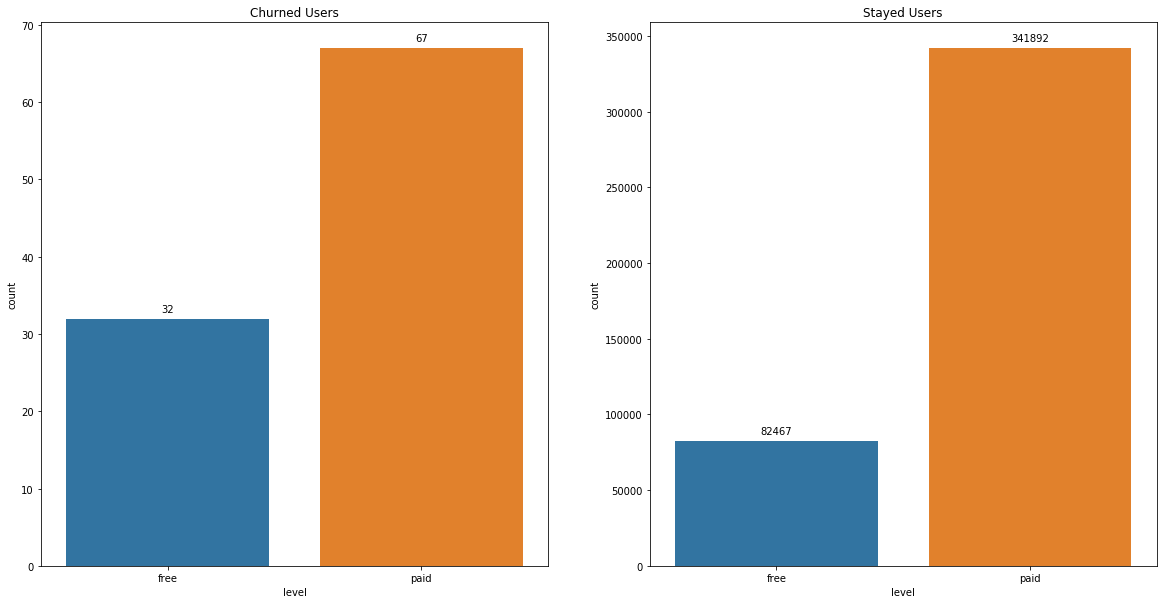

In [22]:
plot([df_level_churn, df_level_login], 'level')

**Note:** From the plot above, we can clearly see that paid users tend to cancel Sparkify. However, paid users also tend to stay with Sparkify, and so we would need to look at more attributes to see how churned and stayed users behave. 

In [23]:
# plot timestamp of for churned and stayed users

In [24]:
# convert epoch timestamps to readable timestamps
convert_time = udf(lambda x: datetime.fromtimestamp(x/1000).strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn("time", convert_time(df.ts))

In [25]:
df.select(["userId", "auth", "time", "level", "page"]).dropDuplicates().sort("auth").show()

+------+---------+-------------------+-----+--------------------+
|userId|     auth|               time|level|                page|
+------+---------+-------------------+-----+--------------------+
|100003|Cancelled|2018-11-08 07:19:52| paid|Cancellation Conf...|
|   162|Cancelled|2018-11-12 20:43:41| paid|Cancellation Conf...|
|   124|Cancelled|2018-11-11 15:09:43| paid|Cancellation Conf...|
|   187|Cancelled|2018-10-10 23:11:31| free|Cancellation Conf...|
|   132|Cancelled|2018-10-08 23:31:53| paid|Cancellation Conf...|
|   188|Cancelled|2018-11-16 21:45:08| paid|Cancellation Conf...|
|    11|Cancelled|2018-11-24 00:22:02| paid|Cancellation Conf...|
|   288|Cancelled|2018-11-15 03:59:41| paid|Cancellation Conf...|
|    18|Cancelled|2018-11-29 20:13:18| paid|Cancellation Conf...|
|   246|Cancelled|2018-11-04 23:33:04| paid|Cancellation Conf...|
|300004|Cancelled|2018-10-28 00:02:40| paid|Cancellation Conf...|
|100048|Cancelled|2018-11-09 02:48:07| paid|Cancellation Conf...|
|   234|Ca

In [26]:
# lambda functions for getting hour and weekday from 'time' attribute
get_hour = udf(lambda x: datetime.fromtimestamp(x/1000).hour)
get_day = udf(lambda x: datetime.fromtimestamp(x/1000).isoweekday())

In [27]:
df = df.withColumn("hour", get_hour(df.ts))
df = df.withColumn("day", get_day(df.ts))

In [28]:
df.select(["userId", "auth", "time", "hour", "day"]).dropDuplicates().sort("auth").show()

+------+---------+-------------------+----+---+
|userId|     auth|               time|hour|day|
+------+---------+-------------------+----+---+
|200013|Cancelled|2018-11-05 09:06:33|   9|  1|
|100012|Cancelled|2018-11-06 14:35:50|  14|  2|
|100043|Cancelled|2018-11-09 11:16:06|  11|  5|
|100025|Cancelled|2018-11-06 12:53:40|  12|  2|
|    81|Cancelled|2018-11-28 21:36:34|  21|  3|
|   124|Cancelled|2018-11-11 15:09:43|  15|  7|
|   221|Cancelled|2018-11-12 18:56:54|  18|  1|
|   123|Cancelled|2018-10-08 00:38:01|   0|  1|
|100040|Cancelled|2018-11-05 00:58:58|   0|  1|
|100036|Cancelled|2018-10-05 16:54:30|  16|  5|
|200024|Cancelled|2018-11-14 10:32:43|  10|  3|
|200039|Cancelled|2018-11-16 09:29:35|   9|  5|
|100017|Cancelled|2018-11-13 13:53:46|  13|  2|
|   246|Cancelled|2018-11-04 23:33:04|  23|  7|
|100048|Cancelled|2018-11-09 02:48:07|   2|  5|
|200016|Cancelled|2018-10-05 20:23:34|  20|  5|
|   296|Cancelled|2018-10-10 16:00:34|  16|  3|
|    16|Cancelled|2018-11-02 08:31:27|  

In [29]:
# dataframes of churned and stayed users for 'hour' attribute
df_hour_churn = df.filter(df.auth == 'Cancelled').select(['auth', 'hour']).toPandas()
df_hour_login = df.filter((df.auth == 'Logged In') & (col("userId").isin(users_who_stayed))).select(['auth', 'hour']).toPandas()

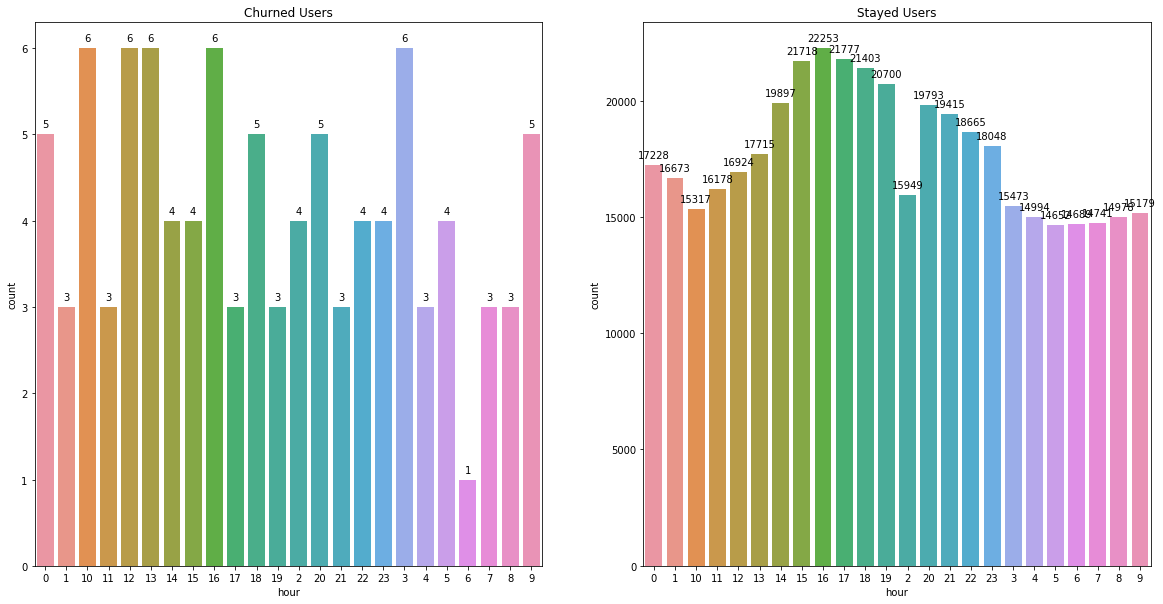

In [30]:
plot([df_hour_churn, df_hour_login], 'hour')

**Note:** We can see that churned users are most active at random times of the day, such as 9am-1pm and late evening around 6pm-11pm, whereas the stayed users are somewhat active in early morning/afternoon around 8am-12pm but most active from evening to night from 2pm-12am. From the hour of the day, we can conclude that stayed users are more consistent with interacting with Sparkify throughout than churned users do.  

In [31]:
# dataframes of churned and stayed users for 'weekday' attribute
df_day_churn = df.filter(df.auth == 'Cancelled').select(['auth', 'day']).toPandas()
df_day_login = df.filter((df.auth == 'Logged In') & (col("userId").isin(users_who_stayed))).select(['auth', 'day']).toPandas()

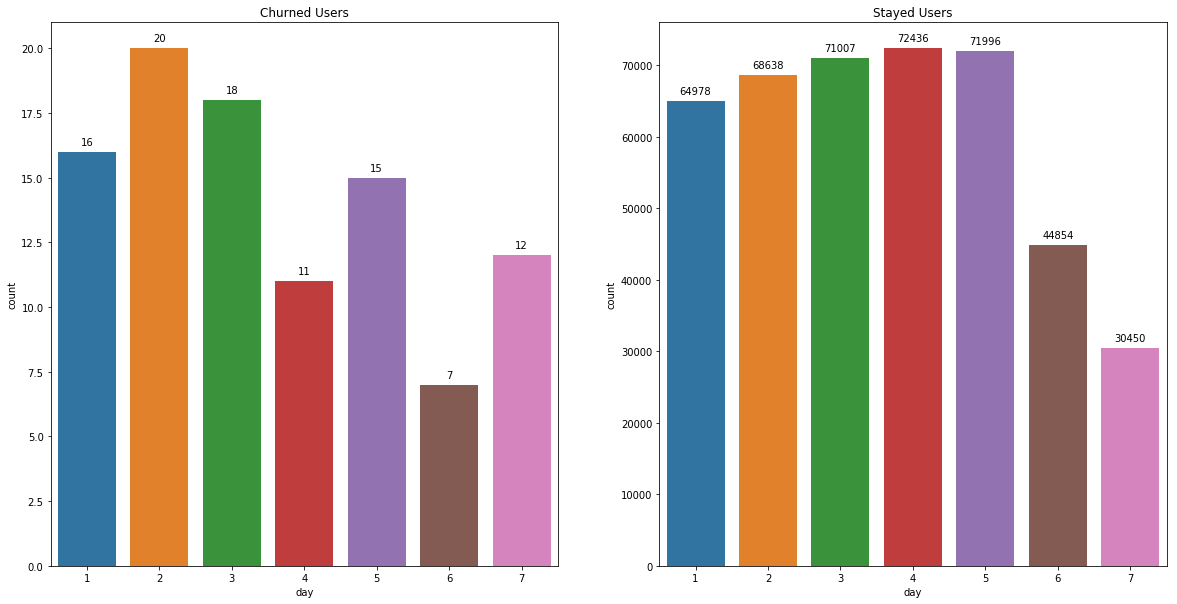

In [32]:
plot([df_day_churn, df_day_login], 'day')

**Note:** From the two plots above where 1-7 represents Monday-Sunday respectively, it is obvious that stayed users interact with Sparkify mostly on weekdays, whereas churned users interact with Sparkify mostly during early days of the week. We can also see how the sporadic the pattern is for churned users compared to stayed users.   

In [33]:
# function to find users' frequency per page
def get_user_counts_per_page(pages, users):
    usersPerPage = []
    start = time.time()
    for page in pages:
        usersCounts = df.filter((df.page == page) & (col("userId").isin(users))) \
            .select('userId') \
            .groupBy('userId') \
            .agg({'userId':'count'}) \
            .withColumnRenamed('count(userId)', 'count').collect()
        usersCountsList = list(map(convert_row_to_string, usersCounts, ['count' for i in range(len(usersCounts))]))
        usersPerPage.append(usersCountsList) if usersCountsList else usersPerPage.append([0])
    end = time.time()
    print("Total time elapsed for extracting churned users' visit count per page:", end-start, "s")
    return usersPerPage

# function to sort page list
def getKey(item):
    return item[1]

In [34]:
churnUserPageList = []
sum_of_page_per_churn_user = get_user_counts_per_page(pageList, churn_users_list)
sum_of_pages = list(map(lambda counts: reduce(lambda x,y: x+y, counts), sum_of_page_per_churn_user))

print("# of visits per page by each churned user:")
for i, (page, sumOfPage) in enumerate(zip(pageList, sum_of_pages)):
    churnUserPageList.append((page, sumOfPage))
    print("{0}: {1}".format(page, sumOfPage))

Total time elapsed for extracting churned users' visit count per page: 33.5034019947052 s
# of visits per page by each churned user:
About: 185
Add Friend: 1537
Add to Playlist: 2259
Cancel: 99
Cancellation Confirmation: 99
Downgrade: 831
Error: 97
Help: 517
Home: 3778
Logout: 1184
NextSong: 84359
Roll Advert: 2186
Save Settings: 104
Settings: 619
Submit Downgrade: 29
Submit Upgrade: 70
Thumbs Down: 1156
Thumbs Up: 4300
Upgrade: 237


In [35]:
# sort page list from in descending order for visit frequency
sum_of_pages.sort(reverse=True)
churnUserPageList = sorted(churnUserPageList, key=getKey, reverse=True)

sortedChurnUserPageList = []
for pair in churnUserPageList:
    sortedChurnUserPageList.append(pair[0])

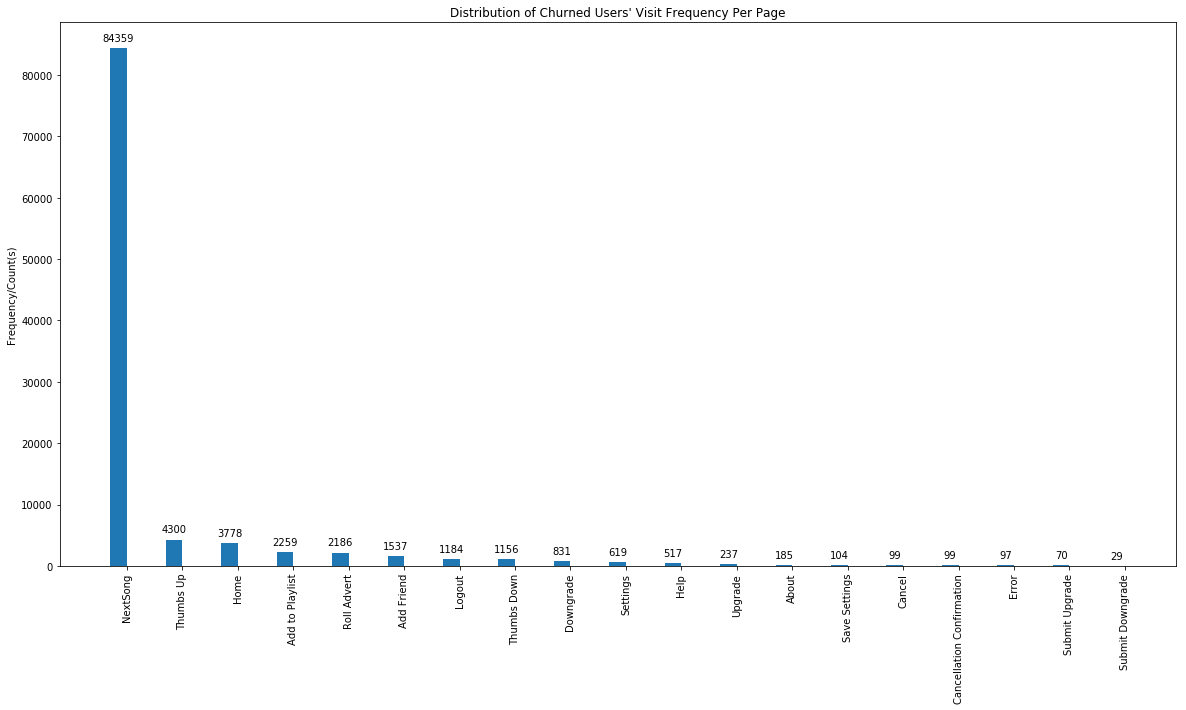

In [36]:
# Distribution of the frequency at which churned users visited each page
fig, ax = plt.subplots(figsize=(20, 10))
x = np.arange(len(sortedChurnUserPageList))
width = 0.3

bar = ax.bar(x - width/2, sum_of_pages, width)

ax.set_ylabel("Frequency/Count(s)")
ax.set_title("Distribution of Churned Users' Visit Frequency Per Page")
ax.set_xticks(x)
ax.set_xticklabels(sortedChurnUserPageList, rotation='vertical')

for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x() + p.get_width() / 2, p.get_height()), ha = 'center', \
                  va = 'center', xytext = (0, 10), textcoords = 'offset points')

ax.legend()

In [37]:
stayedUsersPageList = []
sum_of_page_per_stayed_user = get_user_counts_per_page(pageList, users_who_stayed)
sum_of_pages_stayed_users = list(map(lambda counts: reduce(lambda x,y: x+y, counts), sum_of_page_per_stayed_user))

print("# of visits per page by each stayed user:")
for i, (page, sumOfPage) in enumerate(zip(pageList, sum_of_pages_stayed_users)):
    stayedUsersPageList.append((page, sumOfPage))
    print("{0}: {1}".format(page, sumOfPage))

Total time elapsed for extracting churned users' visit count per page: 40.85166549682617 s
# of visits per page by each stayed user:
About: 841
Add Friend: 6550
Add to Playlist: 10090
Cancel: 0
Cancellation Confirmation: 0
Downgrade: 2980
Error: 406
Help: 2127
Home: 15311
Logout: 4806
NextSong: 348518
Roll Advert: 5587
Save Settings: 481
Settings: 2345
Submit Downgrade: 88
Submit Upgrade: 217
Thumbs Down: 3755
Thumbs Up: 19526
Upgrade: 731


In [38]:
# sort page list from in descending order for visit frequency
sum_of_pages_stayed_users.sort(reverse=True)
stayedUsersPageList = sorted(stayedUsersPageList, key=getKey, reverse=True)

sortedPageListForStayedUsers = []
for pair in stayedUsersPageList:
    sortedPageListForStayedUsers.append(pair[0])

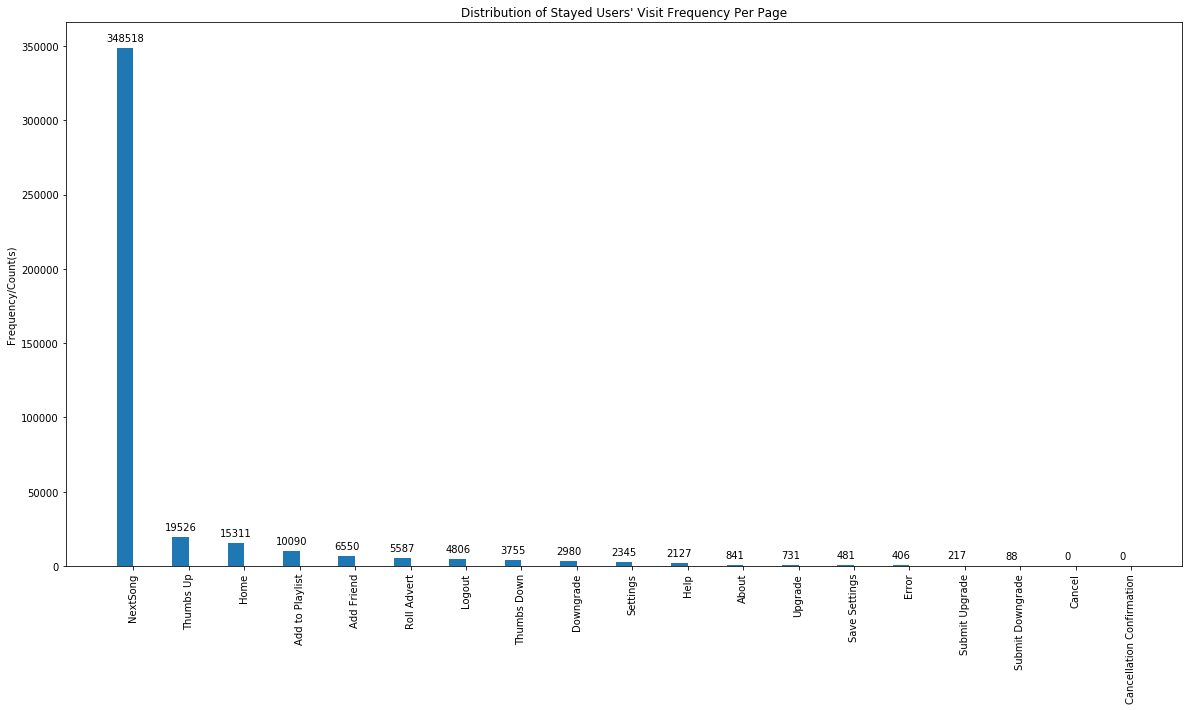

In [39]:
# Distribution of the frequency at which churned users visited each page
fig, ax = plt.subplots(figsize=(20, 10))
x = np.arange(len(sortedPageListForStayedUsers))
width = 0.3

bar = ax.bar(x - width/2, sum_of_pages_stayed_users, width)

ax.set_ylabel("Frequency/Count(s)")
ax.set_title("Distribution of Stayed Users' Visit Frequency Per Page")
ax.set_xticks(x)
ax.set_xticklabels(sortedPageListForStayedUsers, rotation='vertical')

for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x() + p.get_width() / 2, p.get_height()), ha = 'center', \
                  va = 'center', xytext = (0, 10), textcoords = 'offset points')

ax.legend()

In [40]:
# total event visit counts of churned and stayed users
totalCountsOfChurnUsers = reduce(lambda x, y: x+y, sum_of_pages)
totalCountsOfStayedUsers = reduce(lambda x, y: x+y, sum_of_pages_stayed_users)

In [41]:
# calculate how many counts of 'Downgrade' and 'Thumbs Down' events of stayed and cancelled users, which are usually  
# indicators of unsatisified users, are in the total number of stayed and cancelled users 
churnDowngrade = dict(churnUserPageList)['Downgrade'] / totalCountsOfChurnUsers
stayedDowngrade = dict(stayedUsersPageList)['Downgrade'] / totalCountsOfStayedUsers
churnThumbsDown = dict(churnUserPageList)['Thumbs Down'] / totalCountsOfChurnUsers
stayedThumbsDown = dict(stayedUsersPageList)['Thumbs Down'] / totalCountsOfStayedUsers

print("Relative proportion of 'Downgrade' in churned users group: ", churnDowngrade)
print("Relative proportion of 'Downgrade' in stayed users group: ", stayedDowngrade)
print("Relative proportion of 'Thumbs Down' in churned users group: ", churnThumbsDown)
print("Relative proportion of 'Thumbs Down' in stayed users group: ", stayedThumbsDown)

Relative proportion of 'Downgrade' in churned users group:  0.008017675549466453
Relative proportion of 'Downgrade' in stayed users group:  0.007022356071156733
Relative proportion of 'Thumbs Down' in churned users group:  0.011153348899137449
Relative proportion of 'Thumbs Down' in stayed users group:  0.008848639948722661


In [42]:
# how many counts of 'Add Friend', 'Upgrade', 'Add to Playlist', and 'Thumbs Up' events of stayed and cancelled users, which 
# are indicators of how well users interact with the service, are in the total number of stayed and cancelled users 
churnAddF = dict(churnUserPageList)['Add Friend'] / totalCountsOfChurnUsers
stayedAddF = dict(stayedUsersPageList)['Add Friend'] / totalCountsOfStayedUsers
churnUpgrade = dict(churnUserPageList)['Upgrade'] / totalCountsOfChurnUsers
stayedUpgrade = dict(stayedUsersPageList)['Upgrade'] / totalCountsOfStayedUsers
churnAddP = dict(churnUserPageList)['Add to Playlist'] / totalCountsOfChurnUsers
stayedAddP = dict(stayedUsersPageList)['Add to Playlist'] / totalCountsOfStayedUsers
churnThumbsUp = dict(churnUserPageList)['Thumbs Up'] / totalCountsOfChurnUsers
stayedThumbsUp = dict(stayedUsersPageList)['Thumbs Up'] / totalCountsOfStayedUsers

print("Relative proportion of 'Add Friend' in churned users group: ", churnAddF)
print("Relative proportion of 'Add Friend' in stayed users group: ", stayedAddF)
print("Relative proportion of 'Upgrade' in churned users group: ", churnUpgrade)
print("Relative proportion of 'Upgrade' in stayed users group: ", stayedUpgrade)
print("Relative proportion of 'Add to Playlist'' in churned users group: ", churnAddP)
print("Relative proportion of 'Add to Playlist' in stayed users group: ", stayedAddP)
print("Relative proportion of 'Thumbs Up' in churned users group: ", churnThumbsUp)
print("Relative proportion of 'Thumbs Up' in stayed users group: ", stayedThumbsUp)

Relative proportion of 'Add Friend' in churned users group:  0.014829322887520984
Relative proportion of 'Add Friend' in stayed users group:  0.015435044384589463
Relative proportion of 'Upgrade' in churned users group:  0.002286629488837003
Relative proportion of 'Upgrade' in stayed users group:  0.0017225980832267019
Relative proportion of 'Add to Playlist'' in churned users group:  0.021795341836636242
Relative proportion of 'Add to Playlist' in stayed users group:  0.023777037838245446
Relative proportion of 'Thumbs Up' in churned users group:  0.0414873704725701
Relative proportion of 'Thumbs Up' in stayed users group:  0.04601292773335784


**Note:** From the bar graphs analyzing the user behaviors between users who stayed and churned, users who stayed and churned both like to explore different kinds of songs with their frequent interaction with the "NextSong" and "Home" events. However, when we look at indicators that show the potential unsatisfaction from the users about the service, we can see how churned users tend to downgrade and commit a 'Thumbs Down' event more frequently than stayed users do, as calculated in the cells above. Also, I used events, such as 'Add Friend', 'Upgrade', 'Add to Playlist', and 'Thumbs Up', as indicators about how well the users interact with the service, and the results calculated above show that stayed users commit 'Add Friend', 'Add to Playlist', and 'Thumbs Up' events more frequently than churned users, except for 'Upgrade'. I believe that even though churned users upgrade their service more, but were unsatisfied with the service which led to their eventual cancellation of the service.       

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [43]:
df.show()

+---------+-------------+-----+------+---------------+---------+------+-------------+------+-------------------+----+---+
|     auth|itemInSession|level|method|           page|sessionId|status|           ts|userId|               time|hour|day|
+---------+-------------+-----+------+---------------+---------+------+-------------+------+-------------------+----+---+
|Logged In|           20| free|   PUT|       NextSong|      292|   200|1538352011000|   293|2018-10-01 00:00:11|   0|  1|
|Logged In|           74| free|   PUT|       NextSong|       97|   200|1538352025000|    98|2018-10-01 00:00:25|   0|  1|
|Logged In|          184| paid|   PUT|       NextSong|      178|   200|1538352118000|   179|2018-10-01 00:01:58|   0|  1|
|Logged In|          185| paid|   PUT|         Logout|      178|   307|1538352119000|   179|2018-10-01 00:01:59|   0|  1|
|Logged In|           22| paid|   PUT|       NextSong|      245|   200|1538352124000|   246|2018-10-01 00:02:04|   0|  1|
|Logged In|          266

In [44]:
# Remove the attributes not considered for classification
df = df.drop(*['auth', 'method', 'sessionId', 'ts', 'status'])
df.show()

+-------------+-----+---------------+------+-------------------+----+---+
|itemInSession|level|           page|userId|               time|hour|day|
+-------------+-----+---------------+------+-------------------+----+---+
|           20| free|       NextSong|   293|2018-10-01 00:00:11|   0|  1|
|           74| free|       NextSong|    98|2018-10-01 00:00:25|   0|  1|
|          184| paid|       NextSong|   179|2018-10-01 00:01:58|   0|  1|
|          185| paid|         Logout|   179|2018-10-01 00:01:59|   0|  1|
|           22| paid|       NextSong|   246|2018-10-01 00:02:04|   0|  1|
|          266| paid|       NextSong|   163|2018-10-01 00:02:05|   0|  1|
|          190| paid|           Home|   179|2018-10-01 00:02:56|   0|  1|
|          107| free|       NextSong|   175|2018-10-01 00:03:35|   0|  1|
|            0| free|           Home|   100|2018-10-01 00:04:01|   0|  1|
|            1| free|       NextSong|   100|2018-10-01 00:04:19|   0|  1|
|          267| paid|       NextSong| 

### Define features

In [45]:
# 'free' or 'paid' levels for each user
df_free = df.filter(df.level == 'free') \
               .select(['userId', 'level']) \
               .dropDuplicates().withColumnRenamed('level', 'freeLevel')
df_paid = df.filter(df.level == 'paid') \
               .select(['userId', 'level']) \
               .dropDuplicates().withColumnRenamed('level', 'paidLevel')

In [46]:
# initial set up of joined feature DF list
df_processed = df_free.join(df_paid, ['userId'], how='full')

In [47]:
# visit frequency of each page by each user and join with 'df_processed' DF
pageDFList = []

for page in pageList:
    df_temp = df.filter(df.page == page) \
               .select(['userId', 'page']) \
               .groupBy('userId') \
               .agg({'page': 'count'}).withColumnRenamed('count(page)', '{0}Counts'.format(page.replace(" ", "")))
    pageDFList.append(df_temp)

In [48]:
# visit frequency of each quarter of the day by each user
firstQCond = (df.hour == 0) | (df.hour == 1) | (df.hour == 2) | (df.hour == 3) | (df.hour == 4) | (df.hour == 5)
secondQCond = (df.hour == 6) | (df.hour == 7) | (df.hour == 8) | (df.hour == 9) | (df.hour == 10) | (df.hour == 11)
thirdQCond = (df.hour == 12) | (df.hour == 13) | (df.hour == 14) | (df.hour == 15) | (df.hour == 16) | (df.hour == 17)
fourthQCond = (df.hour == 18) | (df.hour == 19) | (df.hour == 20) | (df.hour == 21) | (df.hour == 22) | (df.hour == 23)

hourDFList = []

for i, cond in enumerate([firstQCond, secondQCond, thirdQCond, fourthQCond], 1): 
    df_temp = df.filter(cond) \
               .select(['userId', 'hour']) \
               .groupBy('userId') \
               .agg({'hour': 'count'}).withColumnRenamed('count(hour)', '{0}QDayCounts'.format(str(i)))
    hourDFList.append(df_temp)

In [49]:
# visit frequency of weekdays and weekends by each user
weekDayCond = (df.day == 1) | (df.day == 2) | (df.day == 3) | (df.day == 4) | (df.day == 5)
weekendCond = (df.day == 6) | (df.day == 7)

dayDFList = []

df_weekday = df.filter(weekDayCond) \
               .select(['userId', 'day']) \
               .groupBy('userId') \
               .agg({'day': 'count'}).withColumnRenamed('count(day)', 'weekdayCounts')

df_weekend = df.filter(weekendCond) \
               .select(['userId', 'day']) \
               .groupBy('userId') \
               .agg({'day': 'count'}).withColumnRenamed('count(day)', 'weekendCounts')

dayDFList.append(df_weekday)
dayDFList.append(df_weekend)

In [50]:
# list of feature DFs
featuresDFList = []

for f in [pageDFList, hourDFList, dayDFList]:
    featuresDFList.extend(f) 

In [51]:
featuresDFList

[DataFrame[userId: string, AboutCounts: bigint],
 DataFrame[userId: string, AddFriendCounts: bigint],
 DataFrame[userId: string, AddtoPlaylistCounts: bigint],
 DataFrame[userId: string, CancelCounts: bigint],
 DataFrame[userId: string, CancellationConfirmationCounts: bigint],
 DataFrame[userId: string, DowngradeCounts: bigint],
 DataFrame[userId: string, ErrorCounts: bigint],
 DataFrame[userId: string, HelpCounts: bigint],
 DataFrame[userId: string, HomeCounts: bigint],
 DataFrame[userId: string, LogoutCounts: bigint],
 DataFrame[userId: string, NextSongCounts: bigint],
 DataFrame[userId: string, RollAdvertCounts: bigint],
 DataFrame[userId: string, SaveSettingsCounts: bigint],
 DataFrame[userId: string, SettingsCounts: bigint],
 DataFrame[userId: string, SubmitDowngradeCounts: bigint],
 DataFrame[userId: string, SubmitUpgradeCounts: bigint],
 DataFrame[userId: string, ThumbsDownCounts: bigint],
 DataFrame[userId: string, ThumbsUpCounts: bigint],
 DataFrame[userId: string, UpgradeCount

In [52]:
# generate new DF for classification with feature DFs list
for f in featuresDFList:
    df_processed = df_processed.join(f, ['userId'], how='full')

In [53]:
df_processed.show()

+------+---------+---------+-----------+---------------+-------------------+------------+------------------------------+---------------+-----------+----------+----------+------------+--------------+----------------+------------------+--------------+---------------------+-------------------+----------------+--------------+-------------+-----------+-----------+-----------+-----------+-------------+-------------+
|userId|freeLevel|paidLevel|AboutCounts|AddFriendCounts|AddtoPlaylistCounts|CancelCounts|CancellationConfirmationCounts|DowngradeCounts|ErrorCounts|HelpCounts|HomeCounts|LogoutCounts|NextSongCounts|RollAdvertCounts|SaveSettingsCounts|SettingsCounts|SubmitDowngradeCounts|SubmitUpgradeCounts|ThumbsDownCounts|ThumbsUpCounts|UpgradeCounts|1QDayCounts|2QDayCounts|3QDayCounts|4QDayCounts|weekdayCounts|weekendCounts|
+------+---------+---------+-----------+---------------+-------------------+------------+------------------------------+---------------+-----------+----------+----------+--

In [54]:
null_number = df_processed.toPandas().isnull().sum()
null_number

userId                              0
freeLevel                          78
paidLevel                         127
AboutCounts                       157
AddFriendCounts                    39
AddtoPlaylistCounts                20
CancelCounts                      349
CancellationConfirmationCounts    349
DowngradeCounts                   147
ErrorCounts                       225
HelpCounts                         88
HomeCounts                          8
LogoutCounts                       22
NextSongCounts                      0
RollAdvertCounts                   53
SaveSettingsCounts                206
SettingsCounts                     69
SubmitDowngradeCounts             351
SubmitUpgradeCounts               215
ThumbsDownCounts                   59
ThumbsUpCounts                      9
UpgradeCounts                     133
1QDayCounts                        54
2QDayCounts                        48
3QDayCounts                        22
4QDayCounts                        30
weekdayCount

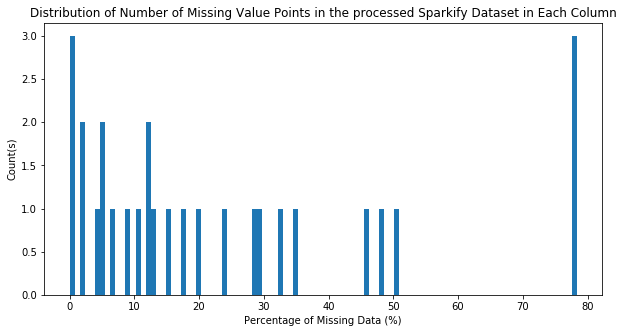

In [55]:
plt.figure(figsize=(10, 5))
plt.title('Distribution of Number of Missing Value Points in the processed Sparkify Dataset in Each Column')
plt.hist(null_number / df_processed.count() * 100, bins=100)
plt.xlabel('Percentage of Missing Data (%)')
plt.ylabel('Count(s)')
plt.show()

In [56]:
# Remove 'CancelCounts' attribute
df_processed = df_processed.drop('CancelCounts')

In [57]:
# fill all null values with 0
df_processed = df_processed.fillna(0)
df_processed.toPandas().isnull().sum()

userId                              0
freeLevel                          78
paidLevel                         127
AboutCounts                         0
AddFriendCounts                     0
AddtoPlaylistCounts                 0
CancellationConfirmationCounts      0
DowngradeCounts                     0
ErrorCounts                         0
HelpCounts                          0
HomeCounts                          0
LogoutCounts                        0
NextSongCounts                      0
RollAdvertCounts                    0
SaveSettingsCounts                  0
SettingsCounts                      0
SubmitDowngradeCounts               0
SubmitUpgradeCounts                 0
ThumbsDownCounts                    0
ThumbsUpCounts                      0
UpgradeCounts                       0
1QDayCounts                         0
2QDayCounts                         0
3QDayCounts                         0
4QDayCounts                         0
weekdayCounts                       0
weekendCount

In [58]:
fill_null = udf(lambda x: 1 if x else 0)
df_processed = df_processed.withColumn("freeLevel", fill_null(df_processed.freeLevel))
df_processed = df_processed.withColumn("paidLevel", fill_null(df_processed.paidLevel))

In [59]:
df_processed.toPandas().isnull().sum()

userId                            0
freeLevel                         0
paidLevel                         0
AboutCounts                       0
AddFriendCounts                   0
AddtoPlaylistCounts               0
CancellationConfirmationCounts    0
DowngradeCounts                   0
ErrorCounts                       0
HelpCounts                        0
HomeCounts                        0
LogoutCounts                      0
NextSongCounts                    0
RollAdvertCounts                  0
SaveSettingsCounts                0
SettingsCounts                    0
SubmitDowngradeCounts             0
SubmitUpgradeCounts               0
ThumbsDownCounts                  0
ThumbsUpCounts                    0
UpgradeCounts                     0
1QDayCounts                       0
2QDayCounts                       0
3QDayCounts                       0
4QDayCounts                       0
weekdayCounts                     0
weekendCounts                     0
dtype: int64

In [60]:
# define 'Churn' based on 'CancellationConfirmationCounts' attribute
# value of 0 refers to not churned users, whereas value of 1 refers to churned users
get_churn = udf(lambda x: 1 if int(x) > 0 else 0)
df_processed = df_processed.withColumn("Churn", get_churn(df_processed.CancellationConfirmationCounts))

In [61]:
# convert column datatypes to float for classification
convert_to_string = udf(lambda x: str(int(x)))
df_processed = df_processed.select(*(col(c).cast("float").alias(c) for c in df_processed.columns))
df_processed = df_processed.withColumn("userId", convert_to_string(df_processed.userId))

In [62]:
# define features for classification
features = df_processed.columns
features.remove('userId')
features.remove('CancellationConfirmationCounts')
features.remove('Churn')

In [63]:
# combine all features by using VecotrAssembler
assembler = VectorAssembler(inputCols=features, outputCol="ChurnFeatures")
df_processed = assembler.transform(df_processed)

In [64]:
# scale features with Normalizer scaler
scaler = Normalizer(inputCol="ChurnFeatures", outputCol="NormedChurnFeatures")
df_processed = scaler.transform(df_processed)

In [65]:
df_processed.select('userId', 'ChurnFeatures', 'NormedChurnFeatures').show()

+------+--------------------+--------------------+
|userId|       ChurnFeatures| NormedChurnFeatures|
+------+--------------------+--------------------+
|100010|(25,[0,3,4,8,9,10...|(25,[0,3,4,8,9,10...|
|200002|[1.0,1.0,1.0,2.0,...|[0.00192119856239...|
|   296|[1.0,1.0,0.0,2.0,...|[0.00473641178047...|
|   125|(25,[0,3,4,7,8,10...|(25,[0,3,4,7,8,10...|
|   124|[0.0,1.0,3.0,26.0...|[0.0,3.7237326618...|
|    51|[0.0,1.0,0.0,3.0,...|[0.0,0.0022722519...|
|     7|[1.0,0.0,2.0,16.0...|[0.00123661932617...|
|200037|(25,[0,2,3,4,8,10...|(25,[0,2,3,4,8,10...|
|   169|(25,[0,3,8,10,11,...|(25,[0,3,8,10,11,...|
|   205|[0.0,1.0,3.0,21.0...|[0.0,5.9569722328...|
|   272|(25,[0,4,8,9,10,1...|(25,[0,4,8,9,10,1...|
|    15|[0.0,1.0,3.0,32.0...|[0.0,3.5262518043...|
|   232|[1.0,1.0,6.0,43.0...|[3.39725598199596...|
|   234|[1.0,1.0,3.0,17.0...|[3.68959005301822...|
|   282|[1.0,1.0,6.0,79.0...|[2.39911313694111...|
|    54|[0.0,1.0,2.0,20.0...|[0.0,0.0013080257...|
|   155|[0.0,1.0,0.0,0.0,...|[0

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [66]:
data = df_processed.select(col("Churn").alias("label"), col("NormedChurnFeatures").alias("features"))

In [67]:
# check for imbalanced dataset
# '0' refers to stayed users, while '1' refers to churned users
numberOfStayedUsers = data.filter(data.label == 0).count()
numberOfChurnUsers = data.filter(data.label == 1).count()

In [68]:
print("# of stayed users in model dataset: ", numberOfStayedUsers)
print("# of churned users in model dataset: ", numberOfChurnUsers)
print("% of stayed users in model dataset: ", numberOfStayedUsers/data.count())
print("% of churned users in model dataset: ", numberOfChurnUsers/data.count())

# of stayed users in model dataset:  349
# of churned users in model dataset:  99
% of stayed users in model dataset:  0.7790178571428571
% of churned users in model dataset:  0.22098214285714285


#### Classification modeling

In [69]:
# split dataset into training and testing dataset
train, test = data.randomSplit([0.9, 0.1], seed=42)

In [70]:
# function for calculating and returning metrics needed for model performance evaluation
def get_metrics(results, beta=1):
    tp, fp, fn, tn = [0 for i in range(4)]
    cm = []
    
    label = results.select(["label"]).collect()
    pred = results.select(["prediction"]).collect()
    labelList = list(map(convert_row_to_string, label, ['label' for i in range(len(label))]))
    predList = list(map(convert_row_to_string, pred, ['prediction' for i in range(len(pred))]))
    
    for i, (l, p) in enumerate(zip(labelList, predList)):    
        if (l == 1) and (p == 1):
            tp += 1
        elif (l == 0) and (p == 1):
            fp += 1
        elif (l == 1) and (p == 0):
            fn += 1
        elif (l == 0) and (p == 0):
            tn += 1
        
    cm = [[tp, fp], [fn, tn]]

    # accuracy = (true pos + true neg) / dataset size 
    accuracy = (cm[0][0] + cm[1][1]) / (sum(cm[0]) + sum(cm[1]))
    
    if cm[0][0] == 0 and cm[0][1] == 0 and cm[1][0] == 0:
        precision, recall, f_score = [1 for i in range(3)]
    elif (cm[0][0] == 0 and cm[0][1] == 0) or (cm[0][0] == 0 and cm[1][0] == 0):
        precision, recall, f_score = [0 for i in range(3)]
    else:
        # precision = true pos / (true pos + false neg)
        precision = cm[0][0] / (cm[0][0] + cm[0][1])
        # recall = true pos / (true pos + false neg)
        recall = cm[0][0] / (cm[0][0] + cm[1][0])
        # f_score = (1 + beta^2) * (precision * recall) / ((beta^2 * precision) + recall)
        f_score = (1 + beta*beta) * (precision * recall) / ((beta*beta * precision) + recall)
    
    return accuracy, precision, recall, f_score

#### Logistic Regression

In [71]:
# evaluator used to evaluate binary classification performance
evaluator = BinaryClassificationEvaluator()

In [72]:
# fit training data to model and predict
lr = LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)
pred_lr = lr.fit(train).transform(test)
results_lr = pred_lr.select(['prediction', 'label'])

In [73]:
# default value for beta is 1 for F1 score
accuracy, precision, recall, f_score = get_metrics(results_lr)

In [74]:
print("Logistic Regression Metrics:\n")
print("Accuracy = %f" % accuracy)
print("Precison = %f" % precision)
print("Recall = %f" % recall)
print("F1 Score = %f" % f_score)

Logistic Regression Metrics:

Accuracy = 0.840909
Precison = 0.800000
Recall = 0.400000
F1 Score = 0.533333


In [75]:
areaUnderROC = evaluator.evaluate(pred_lr, {evaluator.metricName: "areaUnderROC"})
print("Area Under ROC: %f" % areaUnderROC)

Area Under ROC: 0.752941


#### Random Forest Classifier

In [76]:
rf = RandomForestClassifier()
pred_rf = rf.fit(train).transform(test)
results_rf = pred_rf.select(['prediction', 'label'])

In [77]:
accuracy, precision, recall, f_score = get_metrics(results_rf)

In [78]:
print("Random Forest Classifier Metrics:\n")
print("Accuracy = %f" % accuracy)
print("Precison = %f" % precision)
print("Recall = %f" % recall)
print("F1 Score = %f" % f_score)

Random Forest Classifier Metrics:

Accuracy = 0.795455
Precison = 1.000000
Recall = 0.100000
F1 Score = 0.181818


In [79]:
areaUnderROC = evaluator.evaluate(pred_rf, {evaluator.metricName: "areaUnderROC"})
print("Area Under ROC: %f" % areaUnderROC)

Area Under ROC: 0.679412


#### Gradient-Boosted Tree Classifier

In [80]:
gbt = GBTClassifier(maxIter=10)
pred_gbt = gbt.fit(train).transform(test)
results_gbt = pred_gbt.select(['prediction', 'label'])

In [81]:
accuracy, precision, recall, f_score = get_metrics(results_gbt)

In [82]:
print("Gradient-Boosted Tree Classifier Metrics:\n")
print("Accuracy = %f" % accuracy)
print("Precison = %f" % precision)
print("Recall = %f" % recall)
print("F1 Score = %f" % f_score)

Gradient-Boosted Tree Classifier Metrics:

Accuracy = 0.772727
Precison = 0.500000
Recall = 0.200000
F1 Score = 0.285714


In [83]:
areaUnderROC = evaluator.evaluate(pred_gbt, {evaluator.metricName: "areaUnderROC"})
print("Area Under ROC: %f" % areaUnderROC)

Area Under ROC: 0.594118


From the metrics calculated above, logistic regression, amongst the other two classifiers, performs the best in average in predicting the churn rate for Sparkify with the calculated F1 score of 53.3% and area under receiver-operating characteristic (ROC) of 75.3%.

#### Tune logistic regression model to optimize performance

In [84]:
# deal with imbalanced dataset by under-sampling the stayed users (negative cases) in the dataset and treating churned users 
# (positive cases) with higher weights
numChurned = train.filter(train.label == 1).count()
trainSize = train.count()
balancingRatio = (trainSize - numChurned)/ trainSize

In [85]:
calculate_weights = udf(lambda x: balancingRatio if x == 1 else 1-balancingRatio)
weighted_train = train.withColumn('classWeights', calculate_weights(data.label))
weighted_train = weighted_train.withColumn('classWeights', col('classWeights').cast("float"))

In [86]:
weighted_train.show()

+-----+--------------------+------------+
|label|            features|classWeights|
+-----+--------------------+------------+
|  1.0|(25,[0,3,4,8,9,10...|  0.77970296|
|  1.0|[0.00192119856239...|  0.77970296|
|  0.0|(25,[0,3,4,7,8,10...|  0.22029702|
|  0.0|[0.00123661932617...|  0.22029702|
|  1.0|[0.0,3.7237326618...|  0.77970296|
|  1.0|[0.0,0.0022722519...|  0.77970296|
|  1.0|(25,[0,2,3,4,8,10...|  0.77970296|
|  0.0|(25,[0,3,8,10,11,...|  0.22029702|
|  0.0|[0.0,5.9569722328...|  0.22029702|
|  0.0|(25,[0,4,8,9,10,1...|  0.22029702|
|  0.0|[0.0,3.5262518043...|  0.22029702|
|  0.0|[2.39911313694111...|  0.22029702|
|  0.0|[3.39725598199596...|  0.22029702|
|  1.0|[3.68959005301822...|  0.77970296|
|  0.0|[0.0,0.0046617640...|  0.22029702|
|  1.0|[0.0,0.0020452806...|  0.77970296|
|  1.0|[0.00477415356688...|  0.77970296|
|  1.0|[0.00639385666478...|  0.77970296|
|  0.0|[0.00223549241229...|  0.22029702|
|  1.0|[0.0,0.0038764640...|  0.77970296|
+-----+--------------------+------

In [ ]:
lr = LogisticRegression(labelCol="label", featuresCol="features", weightCol="classWeights")

paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [10, 50])\
    .addGrid(lr.regParam,[0.0, 0.1, 0.5]) \
    .addGrid(lr.elasticNetParam,[0.0, 0.5, 1.0]) \
    .build()

crossval_lr = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)

cvModel_lr = crossval_lr.fit(weighted_train)
cvModel_lr.save('cvModel_lr.model')

In [87]:
cvModel_lr = CrossValidatorModel.load('cvModel_lr.model')

In [88]:
cvModel_lr_preds = cvModel_lr.transform(test)
results_cvModel = cvModel_lr_preds.select(['prediction', 'label'])

In [89]:
accuracy, precision, recall, f_score = get_metrics(results_cvModel)

In [90]:
print("Optimized Logistic Regression Metrics:\n")
print("Accuracy = %f" % accuracy)
print("Precison = %f" % precision)
print("Recall = %f" % recall)
print("F1 Score = %f" % f_score)

Optimized Logistic Regression Metrics:

Accuracy = 0.818182
Precison = 0.571429
Recall = 0.800000
F1 Score = 0.666667


In [91]:
areaUnderROC = evaluator.evaluate(cvModel_lr_preds, {evaluator.metricName: "areaUnderROC"})
print("Area Under ROC: %f" % areaUnderROC)

Area Under ROC: 0.958824


In [92]:
bestModel = cvModel_lr.bestModel
print("Best Model's 'maxIter' Parameter = %f" % bestModel._java_obj.getMaxIter())
print("Best Model's 'regParam' Parameter = %f" % bestModel._java_obj.getRegParam())
print("Best Model's 'elasticNetParam' Parameter = %f" % bestModel._java_obj.getElasticNetParam())

Best Model's 'maxIter' Parameter = 50.000000
Best Model's 'regParam' Parameter = 0.000000
Best Model's 'elasticNetParam' Parameter = 0.000000


As seen from the classification and analysis done above, we can first see that logistic regression performed the best compared to random forest and gradient-boosted tree classifiers as measured with its highest F1 score. However, in order to optimize its F1 score and performance, I tuned the hyperparameters of the logistic regression, as well as made the training dataset more balanced by adding more weights to the churned users (positive cases) since the churned users appeared around 3.5x less likely than stayed users. As a result, the tuned and optmized logistic regression model scored an improved F1 score of 66.7% against the original F1 score of 53.3%, and area under ROC of 95.9% against the original area under ROC of 75.3%.